## TLDR;

- **Unsupervised Learning** -> Clustering algorithms are used for unsupervised learning, ideal for exploratory data analysis.
- **Grouping Data** -> These algorithms group similar data into clusters based on specific criteria.
- **Variety of Applications** -> They're used in diverse fields like customer segmentation, anomaly detection, and more.
- **Different Techniques** -> Various types exist, like K-means and DBSCAN, each with unique strengths and suited for specific data types.
- **Choice of Parameters** -> The selection and tuning of parameters, like the number of clusters, significantly influence the results.

In the vast field of machine learning, clustering algorithms hold a pivotal role. Used as a form of unsupervised learning, they uncover hidden patterns and structures within unlabeled data, making them instrumental for exploratory data analysis. The essence of clustering algorithms lies in their ability to sift through unstructured data and bring together similar items, forming distinct groups or 'clusters' based on defined criteria.

These algorithms have found their place in a myriad of real-world applications. From customer segmentation in marketing strategies, to image segmentation in computer vision, anomaly detection in cybersecurity, and dimensionality reduction in high-dimensional data—clustering algorithms are at the heart of insightful data-driven decision making.

The world of clustering algorithms is diverse, housing various types such as K-means, hierarchical, DBSCAN, and Gaussian Mixture Models, each coming with its unique strengths, limitations, and suitability for certain types of data.

A crucial aspect of working with these algorithms is the specification of parameters. While some algorithms like K-means require the user to define the number of clusters in advance, others, like DBSCAN, determine the number of clusters based on the data itself. The choice and tuning of these parameters can significantly steer the algorithm's effectiveness, making this a critical skill for any data practitioner.

In this blog post, we delve deeper into the intriguing world of clustering algorithms, demystifying their workings, exploring their varieties, and discussing how to choose and fine-tune parameters for optimal results. Stay tuned as we embark on this insightful journey.


## Data Preprocessing

In this initial stage, the goal is to prepare the data for analysis. This involves cleaning the data by removing or filling in missing values, which could be done through various strategies like dropping the missing rows, filling them with mean/median/mode, or using a prediction model. It's also crucial to handle outliers and potentially normalize features if they're on different scales. This stage might also involve dealing with categorical variables using encoding techniques. Effective preprocessing is crucial for reliable results in the subsequent stages.


#TODO add intro to the dataset
dataset can be found [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

| Field                  | Description                                                               |
| ---------------------- | ------------------------------------------------------------------------- |
| CustomerID             | Unique ID assigned to the customer                                        |
| Gender                 | Gender of the customer                                                    |
| Age                    | Age of the customer                                                       |
| Annual Income (k$)     | Annual income of the customer                                             |
| Spending Score (1-100) | Score assigned by the mall based on customer behavior and spending nature |


In [1]:
from functools import lru_cache

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.cluster import HDBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import power_transform, scale
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer

set_matplotlib_formats("svg")
sns.set_palette("tab10")
sns.set_style("darkgrid")
plt.style.use("seaborn-v0_8-darkgrid")
FIGSIZE = (12, 6)

/opt/homebrew/Caskroom/miniconda/base/envs/hypershotgun/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
# | code-fold: show


# Load the customer dataset to analyze shopping patterns
df_mall = pd.read_csv("artifacts/Mall_Customers.csv")

# rename columns to be lowercase, for easy typing
df_mall = df_mall.rename(
    columns={
        "CustomerID ": "id",
        "Gender ": "gender",
        "Age ": "age",
        "Annual Income (k$) ": "income",
        "Spending Score (1-100)": "spending",
    }
)
df_mall["gender"] = df_mall["gender"].str.lower()
df_mall["gender"] = df_mall["gender"].str.strip()


# look at a random sample to validate the contents
print(df_mall.sample(6))

      id  gender  age  income  spending
43    44  female   31      39        61
103  104    male   26      62        55
77    78    male   40      54        48
149  150    male   34      78        90
158  159    male   34      78         1
2      3  female   20      16         6


Upon examination of the dataset, it appears that the 'gender' column is the only non-numeric feature. Specifically, it contains string values categorizing customers as either "Male" or "Female". All other columns - 'id', 'age', 'income', and 'spending' - are numeric data types.

The 'id' column seems to be a unique identifier for each customer. While numeric, this feature has very high cardinality (a distinct value for every customer). Features with high cardinality tend to dominate distance calculations in clustering algorithms and obscure more meaningful patterns in the data. Therefore, we should exclude the customer ID column from the feature set used for clustering.

For the remaining features to function effectively in clustering algorithms, the input features generally need to be numeric rather than categorical strings. Distance-based algorithms like k-means rely on computing distances between data points across features. String categories do not have an inherent numeric ordering, so the distance computations would not be meaningful.

Additionally, when performing exploratory analysis, a numeric encoding often allows easier visualization of the impact of gender relative to the other numeric features. Box plots, scatter plots with color-coded points, and other techniques can provide better insights into how gender correlates with shopper age, income or spending habits when mapped to a numeric form.

Therefore, to enable the application of clustering algorithms and more impactful analysis, we need to process the 'gender' column by encoding the categories as numbers. Common encoding schemes include mapping "Male" and "Female" to 0 and 1 respectively, or using one-hot encoding to create an additional binary feature column for each category. After encoding, gender will be represented numerically like the other existing features.

In summary, as gender is the only non-numeric column, and ID has high cardinality unsuitable for clustering, effectively preparing the data requires encoding the gender categorical data and excluding the customer ID column.


In [4]:
# | code-fold: show

# convert gender to a numerical value via one-hot-encoding
# clustering models usally need numerical values
df_mall = pd.get_dummies(df_mall, columns=["gender"], drop_first=True)

# list with features for easy reference
features = ["age", "income", "spending", "gender_male"]
df_feature = df_mall[features]


# look at a random sample to validate the contents
df_feature.sample(5)

,age,income,spending,gender_male
169,32,87,63,True
138,19,74,10,True
130,47,71,9,True
20,35,24,35,True
32,53,33,4,True


In [5]:
# | code-fold: show
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          200 non-null    int64
 1   income       200 non-null    int64
 2   spending     200 non-null    int64
 3   gender_male  200 non-null    bool 
dtypes: bool(1), int64(3)
memory usage: 5.0 KB


## Exploratory Data Analysis

Visualize the data and derive initial insights.


In [6]:
# | code-fold: show
print(df_feature.describe().T)

          count   mean        std   min    25%   50%   75%    max
age       200.0  38.85  13.969007  18.0  28.75  36.0  49.0   70.0
income    200.0  60.56  26.264721  15.0  41.50  61.5  78.0  137.0
spending  200.0  50.20  25.823522   1.0  34.75  50.0  73.0   99.0


The dataset contains information 200 customers. The average (mean) age is 38.85 years. Ages range from 18 to 70, with 50% of customers aged 36 years or below.

The average annual income is $60,560, ranging from $15,000 to $137,000. 50% of customers earn $61,500 or less.

For the spending score (1-100), the average is 50.2. Half the customers have a spending score of 50 or below. The minimum is 1 and maximum 99, showing a wide range in spending habits.

Overall, we see variation among customers in age, income levels, and purchasing patterns. Clustering algorithms can help segment customers into groups based on these attributes to develop targeted marketing approaches. let us first look at the distributions of the features.


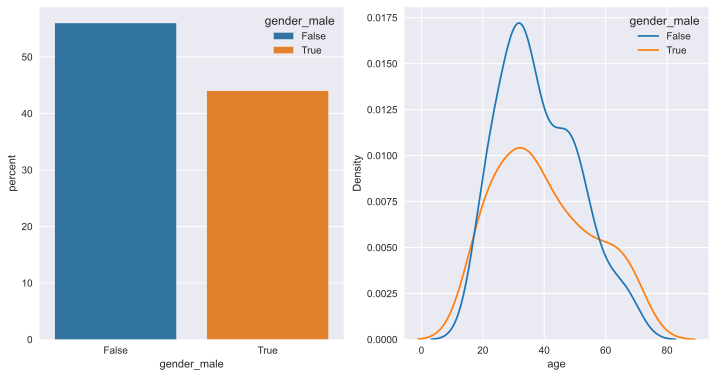

In [7]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

sns.countplot(
    data=df_feature, x="gender_male", stat="percent", hue="gender_male", ax=ax[0]
)

sns.kdeplot(x="age", data=df_feature, hue="gender_male", ax=ax[1])
plt.show()

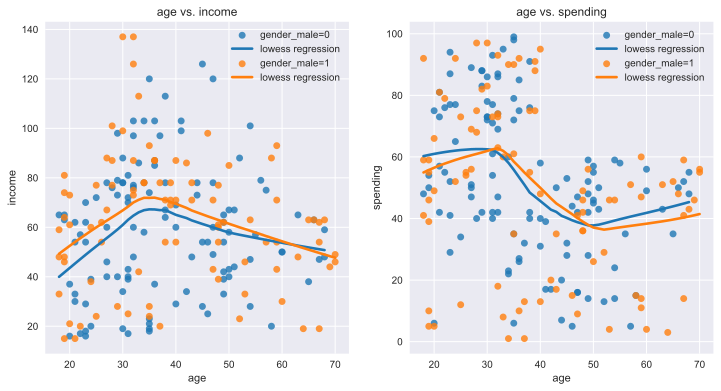

In [8]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

curr_ax = ax[0]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 0],
    x="age",
    y="income",
    color=sns.color_palette()[0],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)


curr_ax = ax[0]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 1],
    x="age",
    y="income",
    color=sns.color_palette()[1],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)
curr_ax.legend(
    ["gender_male=0", "lowess regression", "gender_male=1", "lowess regression"]
)
curr_ax.set_title("age vs. income")


curr_ax = ax[1]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 0],
    x="age",
    y="spending",
    color=sns.color_palette()[0],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)


curr_ax = ax[1]
sns.regplot(
    data=df_feature[df_feature["gender_male"] == 1],
    x="age",
    y="spending",
    color=sns.color_palette()[1],
    order=1,
    lowess=True,
    truncate=True,
    ax=curr_ax,
)
curr_ax.legend(
    ["gender_male=0", "lowess regression", "gender_male=1", "lowess regression"]
)
curr_ax.set_title("age vs. spending")
plt.show()

Text(0.5, 0.98, 'Age vs. Spending')

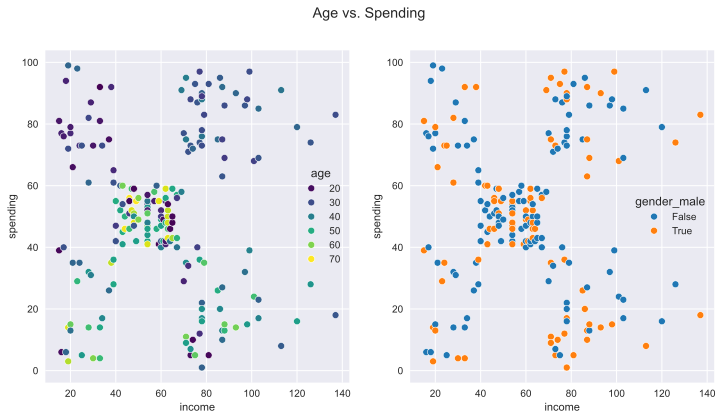

In [9]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

curr_ax = ax[0]
sns.scatterplot(
    data=df_feature,
    x="income",
    y="spending",
    hue="age",
    palette=sns.color_palette("viridis", as_cmap=True),
    # style="gender_male",
    ax=curr_ax,
)


curr_ax = ax[1]
sns.scatterplot(
    data=df_feature,
    x="income",
    y="spending",
    # hue="age",
    # palette=sns.color_palette("viridis", 2),
    hue="gender_male",
    ax=curr_ax,
)

plt.suptitle("Age vs. Spending")

In [10]:
# fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

# curr_ax = ax[0]
# sns.scatterplot(
#     data=df_feature,
#     x="spending",
#     y="age",
#     hue="age",
#     palette=sns.color_palette("viridis", as_cmap=True),
#     # style="gender_male",
#     ax=curr_ax,
# )


# curr_ax = ax[1]
# sns.scatterplot(
#     data=df_feature,
#     x="income",
#     y="age",
#     hue="age",
#     palette=sns.color_palette("viridis", as_cmap=True),
#     ax=curr_ax,
# )
# plt.show()

<Axes: xlabel='si_ratio_clip', ylabel='age'>

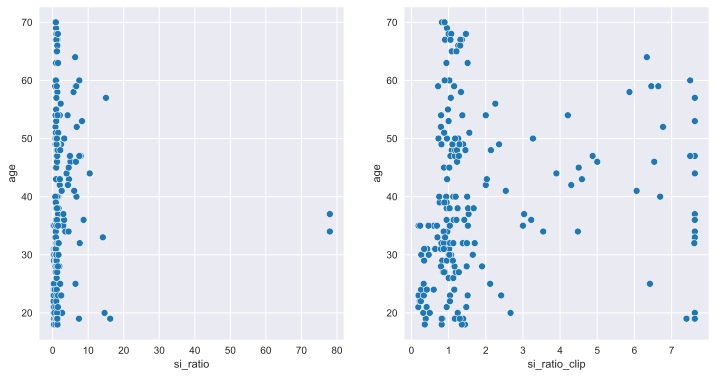

In [11]:
# create a ratio between income and spending
df_ratio = df_feature.assign(si_ratio=df_feature["income"] / df_feature["spending"])

fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)
curr_ax = ax[0]

sns.scatterplot(
    data=df_ratio,
    x="si_ratio",
    y="age",
    ax=curr_ax,
)


# clip to 95% quantile of the si ratio,
# this will zoom into the interesting part of the plot
df_ratio = df_ratio.assign(
    si_ratio_clip=df_ratio["si_ratio"].clip(
        upper=np.quantile(df_ratio["si_ratio"], 0.95)
    )
)

curr_ax = ax[1]
sns.scatterplot(
    data=df_ratio,
    x="si_ratio_clip",
    y="age",
    ax=curr_ax,
)

In [12]:
df_ratio = df_ratio.assign(
    si_ratio_transform=power_transform(
        df_ratio["si_ratio"].values.reshape(-1, 1), method="yeo-johnson"
    )
)

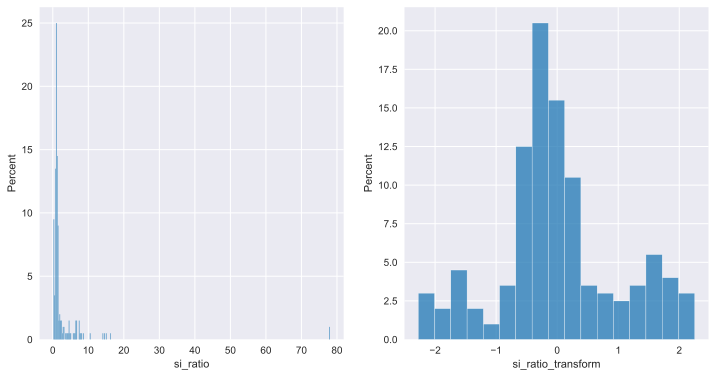

<Figure size 800x550 with 0 Axes>

In [13]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)


plt.figure()
sns.histplot(data=df_ratio["si_ratio"], stat="percent", ax=ax[0])

# df_ratio["si_ratio"].to_numpy().reshape(-1, 1), method="box-cox"
#     ) + 2

sns.histplot(
    data=df_ratio["si_ratio_transform"],
    stat="percent",
    ax=ax[1],
)
plt.show()

In [14]:
@lru_cache(maxsize=None)
def calc_umap(
    n_neighbors=15,
    min_dist=0.15,
    n_components=2,
):
    # data structure, with the goal of a 2D representation.
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=min_dist,
        metric="euclidean",
        random_state=42,
        n_jobs=1,  # setting to 1 to lock in the random state
    )

    # fit the data to the reducer
    return reducer.fit_transform(df_feature)


def plot_umap(embeddings: np.array = None, ax: plt.axes = None):
    # create the scatter plot of the 2 component embedding
    # the order of x,y doesnt matter, the relative distance does
    ax.scatter(x=embeddings[:, 0], y=embeddings[:, 1], s=12, alpha=0.7)

    # remove axis labels and ticks
    # as these are meaningless for umap
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # n_neighbors are formatted as floats  and min_dist are formatted as int
    ax.set_title(f"{n_neighbors=:.0f} {min_dist=:.2f}")

In [15]:
# defining the parameter sweep
range_min_dist = np.linspace(0, 1, 5)  # min_dist
range_n_neighbors = np.arange(10, 14)  # n_neighbors

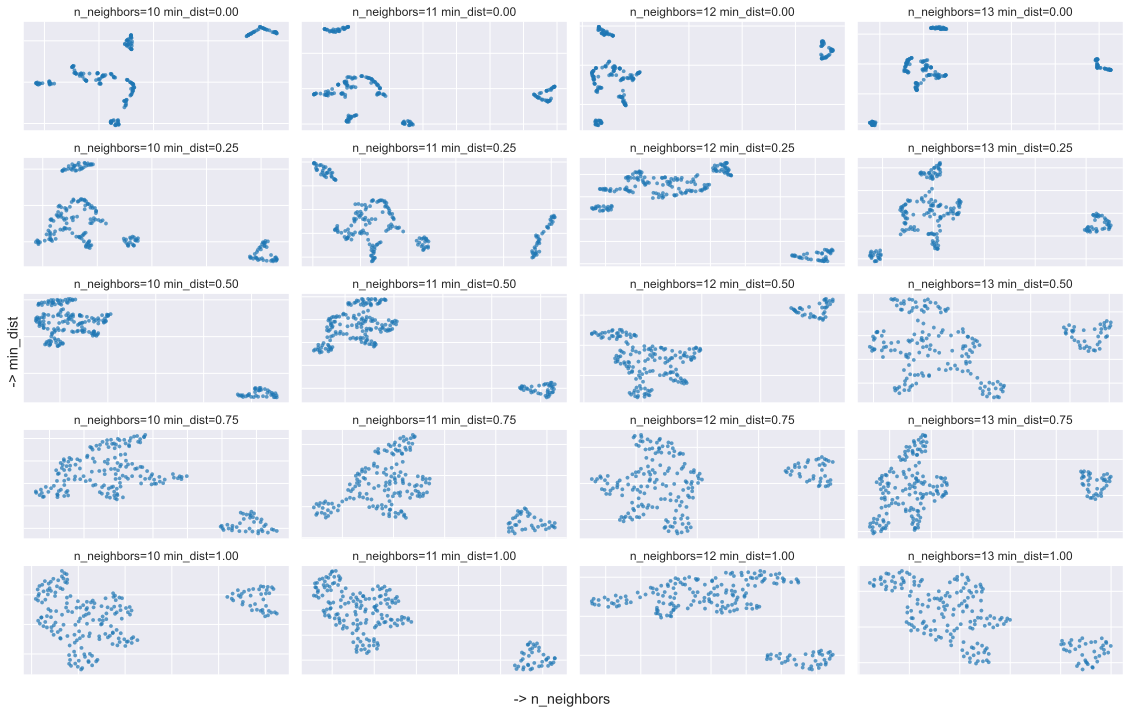

In [16]:
# creating the subplots and performing the embedding with the parameter sweep
fig, ax = plt.subplots(
    nrows=len(range_min_dist), ncols=len(range_n_neighbors), figsize=(16, 10)
)

for i_min_dist, min_dist in enumerate(range_min_dist):
    for i_n_neighbors, n_neighbors in enumerate(range_n_neighbors):
        embeddings = calc_umap(
            n_neighbors=int(n_neighbors),
            min_dist=float(min_dist),
        )
        plot_umap(embeddings=embeddings, ax=ax[i_min_dist, i_n_neighbors])

fig.supxlabel(" -> n_neighbors")
fig.supylabel(" -> min_dist")
fig.tight_layout()
plt.show()

## Feature Engineering

Based on your EDA, create features that might help define customer segmentation, such as total purchase value, average purchase size, frequency of purchase, etc.


- create bins for the age bracket
- calculate descriptive stats for each bracket i.e mean spending size, income
- ratio of income of spending
- normalization of variables -> make comment on the distance calculations


In [17]:
# bin the age variable
binned = pd.cut(
    df_feature["age"],
    bins=[0, 20, 30, 40, 50, 60, 70, 80],
    labels=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ],
)
df_feature = df_feature.assign(age_bin=binned)
df_feature.sample(10)

,age,income,spending,gender_male,age_bin
85,48,54,46,True,4
67,68,48,48,False,6
11,35,19,99,False,3
149,34,78,90,True,3
185,30,99,97,True,2
184,41,99,39,False,4
135,29,73,88,False,2
173,36,87,92,True,3
153,38,78,76,False,3
111,19,63,54,False,1


In [18]:
# ratios
df_feature = df_feature.assign(
    si_ratio=df_feature["income"] / df_feature["spending"],
    sa_ratio=df_feature["age"] / df_feature["spending"],
)
df_feature.sample(10)

,age,income,spending,gender_male,age_bin,si_ratio,sa_ratio
68,19,48,59,True,1,0.813559,0.322034
130,47,71,9,True,4,7.888889,5.222222
52,31,43,54,False,3,0.796296,0.574074
189,36,103,85,False,3,1.211765,0.423529
126,43,71,35,True,4,2.028571,1.228571
94,32,60,42,False,3,1.428571,0.761905
190,34,103,23,False,3,4.478261,1.478261
153,38,78,76,False,3,1.026316,0.500000
55,47,43,41,True,4,1.048780,1.146341
77,40,54,48,True,3,1.125000,0.833333


In [19]:
# turn off the formatter, to increase readability
# fmt: off
# create a new column with the difference between income and the mean income of the gender group
df_feature = df_feature.assign(
    # create a new column with the difference between income and the mean income of the gender group
    income_vs_gender_mean=df_feature['income'] - df_feature.groupby("gender_male",)[["income",]].transform("mean").iloc[:, 0],
    spending_vs_gender_mean=df_feature["spending"] - df_feature.groupby("gender_male")[["spending",]].transform("mean").iloc[:, 0],

    # create a new column with the difference between income and the mean income of the age group
    spending_vs_age_mean=df_feature["spending"] - df_feature.groupby("age_bin",observed=False)[["spending",]].transform("mean").iloc[:, 0],
    income_vs_age_mean=df_feature["spending"] - df_feature.groupby("age_bin",observed=False)[["income",]].transform("mean").iloc[:, 0],
)
# fmt: on

df_feature.sample(10)

,age,income,spending,gender_male,age_bin,si_ratio,sa_ratio,income_vs_gender_mean,spending_vs_gender_mean,spending_vs_age_mean,income_vs_age_mean
151,39,78,88,True,3,0.886364,0.443182,15.772727,39.488636,30.500000,19.366667
133,31,72,71,False,3,1.014085,0.436620,12.750000,19.473214,13.500000,2.366667
120,27,67,56,True,2,1.196429,0.482143,4.772727,7.488636,-11.222222,-0.755556
84,21,54,57,False,2,0.947368,0.368421,-5.250000,5.473214,-10.222222,0.244444
75,26,54,54,True,2,1.000000,0.481481,-8.227273,5.488636,-13.222222,-2.755556
44,49,39,28,False,4,1.392857,1.750000,-20.250000,-23.526786,-6.394737,-35.605263
16,35,21,35,False,3,0.600000,1.000000,-38.250000,-16.526786,-22.500000,-33.633333
99,20,61,49,True,1,1.244898,0.408163,-1.227273,0.488636,4.352941,-2.117647
198,32,137,18,True,3,7.611111,1.777778,74.772727,-30.511364,-39.500000,-50.633333
88,34,58,60,False,3,0.966667,0.566667,-1.250000,8.473214,2.500000,-8.633333


<Axes: xlabel='income_vs_gender_mean', ylabel='Count'>

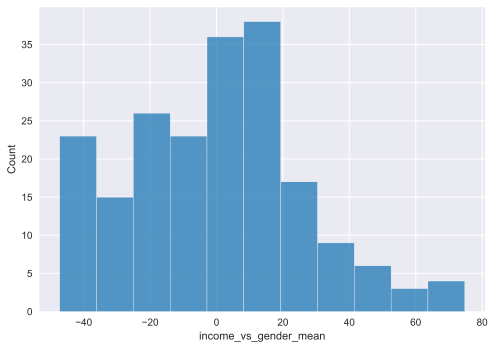

In [20]:
# apply power transform
# sns.histplot(df_feature['age'])
sns.histplot(df_feature["income_vs_gender_mean"])
# sns.histplot(df_feature['age'])
# sns.histplot(df_feature['age'])
# sns.histplot(df_feature['age'])

In [21]:
# casting values to integer in order for scaling later on
df_feature = df_feature.assign(
    age_bin=df_feature["age_bin"].astype(int),
)

df_feature[df_feature.select_dtypes(include="number").columns] = power_transform(
    X=df_feature[df_feature.select_dtypes(include="number").columns],
    method="yeo-johnson",
)
df_feature.sample(10)

,age,income,spending,gender_male,age_bin,si_ratio,sa_ratio,income_vs_gender_mean,spending_vs_gender_mean,spending_vs_age_mean,income_vs_age_mean
77,0.233319,-0.170436,-0.037540,True,-0.113303,-0.126075,-0.001269,-0.279316,-0.020591,-0.537953,-0.431404
121,0.091408,0.315793,-0.346103,False,-0.113303,0.410752,0.171627,0.334914,-0.448683,-0.830815,-0.712264
0,-1.718993,-1.989930,-0.385308,True,-1.892399,-1.563718,-0.708222,-1.895689,-0.370375,-0.390820,-0.127627
124,-1.240020,0.423150,-0.786696,False,-0.918216,0.850576,-0.067075,0.443827,-0.876019,-1.548798,-0.681614
136,0.499911,0.528911,-1.769322,False,0.585358,1.910492,1.820575,0.552075,-1.730499,-1.179020,-1.673974
186,1.085525,1.452380,-0.995062,False,1.209560,1.384239,1.161656,1.545006,-1.070237,-0.501089,-0.853650
34,0.805504,-1.054501,-1.433908,False,0.585358,0.823976,1.515059,-1.019077,-1.458639,-0.933968,-1.435562
74,1.344168,-0.170436,-0.075650,True,1.209560,-0.096729,0.526302,-0.279316,-0.059469,0.611735,-0.039930
18,0.976291,-1.543402,-0.786696,True,1.209560,-0.617649,0.935705,-1.560029,-0.758883,-0.306805,-0.679521
178,1.344168,1.198888,-1.433908,True,1.209560,1.696522,1.630402,1.158482,-1.341524,-0.867364,-1.198914


In [22]:
df_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
age,200.0,7.016610e-16,1.002509,-1.851739,-0.661494,-0.056996,0.805504,1.852811
income,200.0,-5.684342e-16,1.002509,-1.989930,-0.678427,0.114476,0.701866,2.515898
spending,200.0,3.552714e-17,1.002509,-2.100163,-0.553723,0.038318,0.881491,1.786065
age_bin,200.0,5.462297e-16,1.002509,-1.892399,-0.918216,-0.113303,0.585358,1.777954
si_ratio,200.0,4.263256e-16,1.002509,-2.274854,-0.463817,-0.124667,0.335556,2.253114
sa_ratio,200.0,-2.575717e-16,1.002509,-1.693664,-0.914656,0.032022,0.665247,2.116408
income_vs_gender_mean,200.0,-7.105427e-17,1.002509,-1.895689,-0.729683,0.076205,0.633519,2.695342
spending_vs_gender_mean,200.0,-5.329071e-17,1.002509,-1.846407,-0.652651,-0.020890,0.834990,1.886854
spending_vs_age_mean,200.0,-3.108624e-17,1.002509,-2.155238,-0.827041,0.063810,0.678319,2.582476
income_vs_age_mean,200.0,-4.440892e-17,1.002509,-2.047257,-0.712264,0.035377,0.658368,2.158512


## Clustering

Use a suitable clustering algorithm (like K-means or hierarchical clustering) to divide customers into distinct groups.


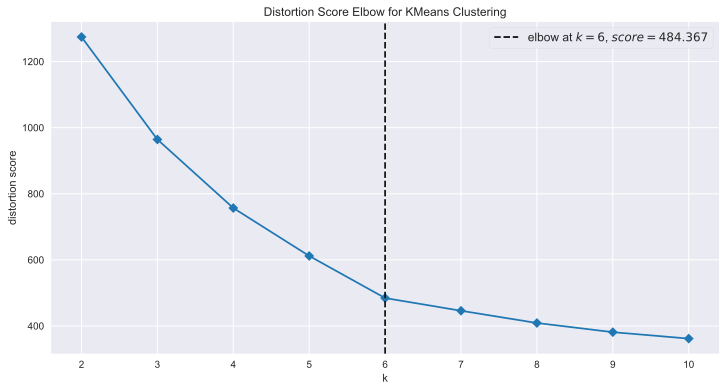

In [23]:
fig, ax = plt.subplots(figsize=FIGSIZE)

_ = kelbow_visualizer(
    KMeans(n_init=10),
    X=df_feature,
    timings=False,
    metric="distortion",
    ax=ax,
)  # distortion: mean sum of squared distances to centers

In [24]:
# fit kmeans for various number of clusters
kmeans_clusters = [KMeans(n_clusters=i, n_init="auto") for i in range(2, 11)]

/var/folders/q6/pntlsv6s1j19xm8fhz9g32fr0000gn/T/ipykernel_54587/1231921934.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


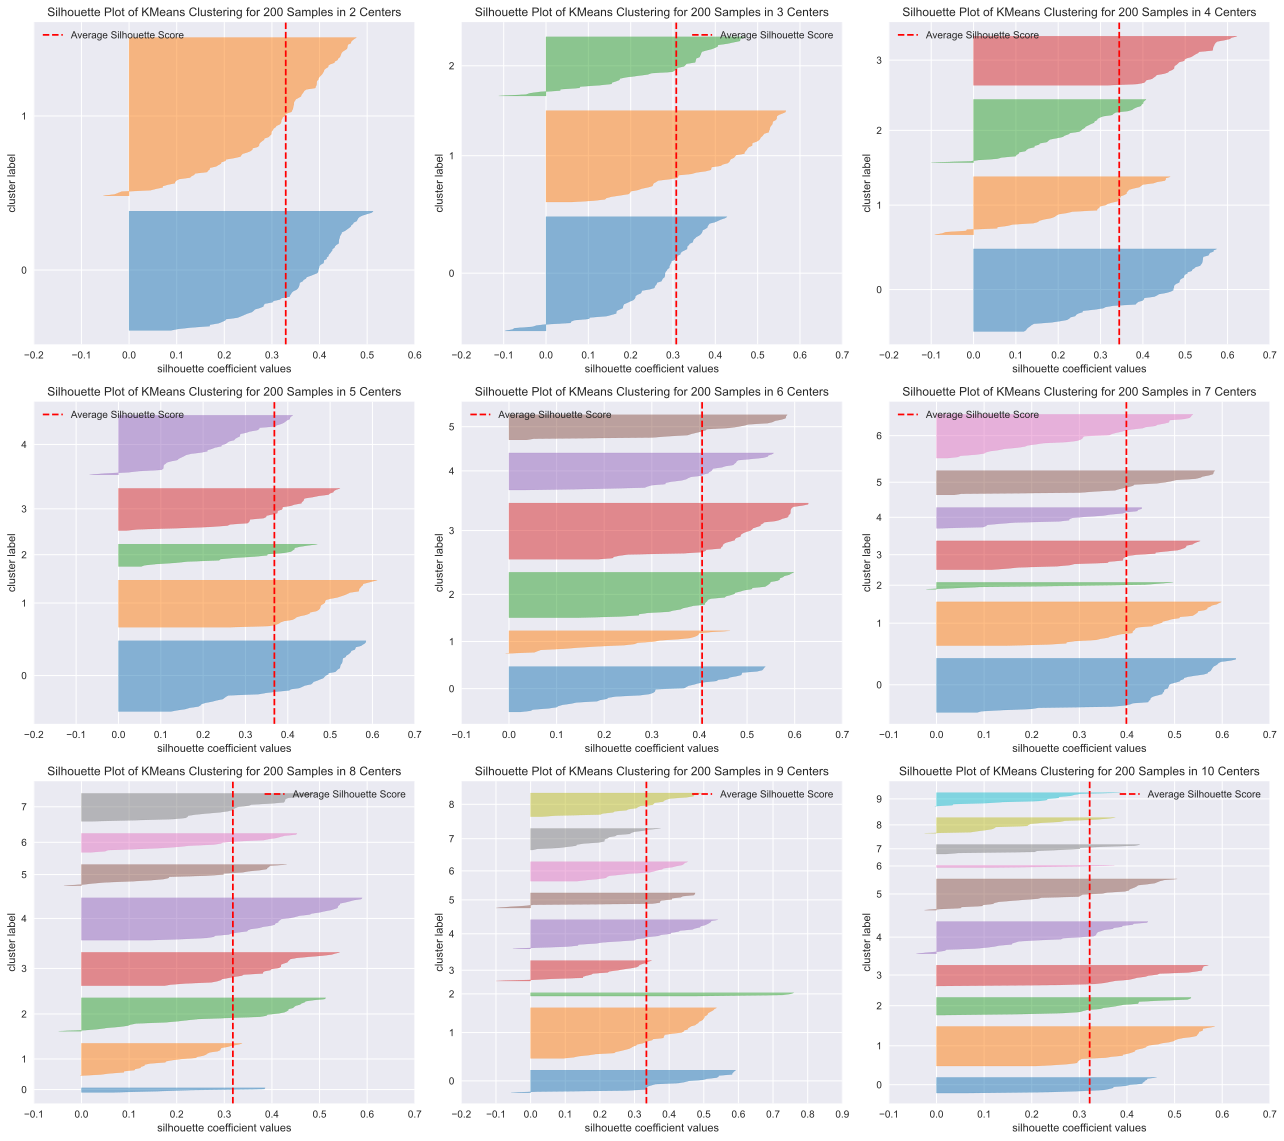

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(18, 16), layout="constrained")

for i, ax in enumerate(axes.flatten()):
    silhouette_visualizer(
        kmeans_clusters[i],
        X=df_feature,
        ax=ax,
        is_fitted=False,
        show=False,
        colors=sns.color_palette("tab10"),
    )
plt.tight_layout()
plt.show()

/var/folders/q6/pntlsv6s1j19xm8fhz9g32fr0000gn/T/ipykernel_54587/1685628906.py:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


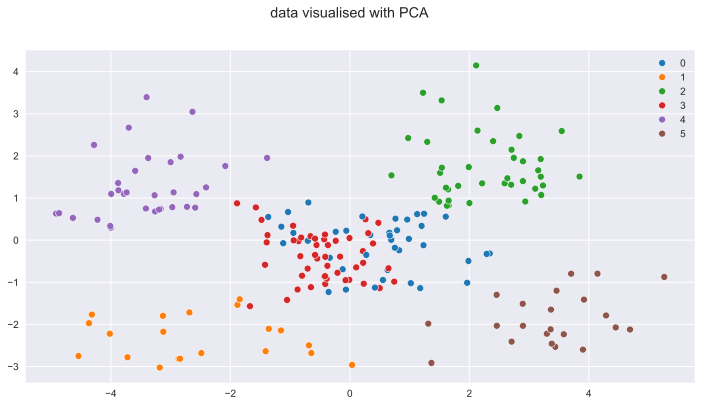

In [26]:
decomp = PCA(n_components=2)
decomp_components = decomp.fit_transform(df_feature)


fig, ax = plt.subplots(figsize=FIGSIZE)
sns.scatterplot(
    x=decomp_components[:, 0],
    y=decomp_components[:, 1],
    hue=kmeans_clusters[4].predict(df_feature),
    palette=sns.color_palette("tab10"),
    ax=ax,
)

plt.suptitle("data visualised with PCA")
plt.show()

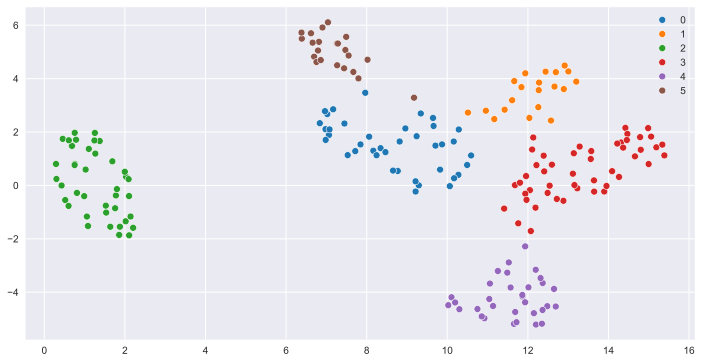

In [27]:
decomp_umap = umap.UMAP(
    n_components=2, min_dist=0.5, n_neighbors=12, n_jobs=1, random_state=92
)
decomp_components_umap = decomp_umap.fit_transform(df_feature)

fig, ax = plt.subplots(figsize=FIGSIZE)

sns.scatterplot(
    x=decomp_components_umap[:, 0],
    y=decomp_components_umap[:, 1],
    hue=kmeans_clusters[4].predict(df_feature),
    palette=sns.color_palette("tab10", 6),
    ax=ax,
)

plt.show()

## Analysis and Evaluation

Analyze each customer group's traits, like average age or buying habits. Use metrics like Silhouette Score or Dunn Index to assess clustering quality, evaluating cluster cohesion and separation. A successful clustering result scores well on these metrics and provides actionable business insights.


In [28]:
df_cluster = df_feature.assign(cluster=kmeans_clusters[4].predict(df_feature))
df_mall_cluster = df_mall.assign(cluster=kmeans_clusters[4].predict(df_feature)).drop(
    columns=["id"]
)

In [29]:
#
df_all = pd.concat([df_mall.drop(columns=["id"]), df_cluster], axis=1)

In [30]:
df_mall_cluster.groupby("cluster", as_index=False).agg(["mean", "min", "max"])

cluster        age             income            spending          \
                mean min max       mean min  max       mean min max   
0       0  26.923077  18  40  56.205128  39   76  49.538462  29  65   
1       1  45.400000  20  67  25.650000  16   39  18.550000   3  40   
2       2  32.692308  27  40  86.538462  69  137  82.128205  63  97   
3       3  55.708333  43  70  54.770833  38   79  48.229167  35  60   
4       4  41.000000  19  59  89.406250  71  137  15.593750   1  39   
5       5  25.045455  18  35  24.636364  15   38  78.181818  39  99   

  gender_male               
         mean    min   max  
0    0.333333  False  True  
1    0.350000  False  True  
2    0.461538  False  True  
3    0.458333  False  True  
4    0.562500  False  True  
5    0.454545  False  True

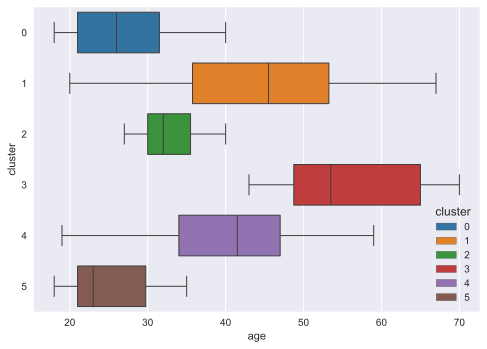

In [31]:
sns.boxplot(
    df_mall_cluster,
    y="cluster",
    x="age",
    orient="h",
    hue="cluster",
    palette=sns.color_palette("tab10", 6),
)

plt.show()

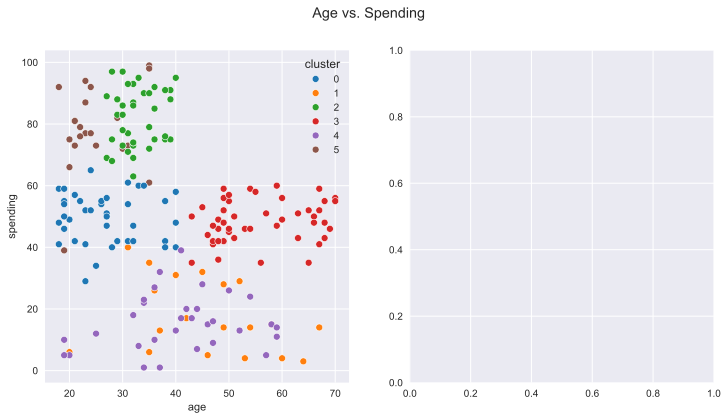

In [43]:
fig, ax = plt.subplots(1, 2, figsize=FIGSIZE)

curr_ax = ax[0]
sns.scatterplot(
    data=df_mall_cluster,
    x="age",
    y="spending",
    hue="cluster",
    palette=sns.color_palette("tab10", 6),
    # style="gender_male",
    ax=curr_ax,
)

# TODO  plot the cluster centroids instead of the individual points
curr_ax = ax[1]
# sns.scatterplot(
#     data=df_mall_cluster,
#     x="age",
#     y="spending",
#     hue="cluster",
#     palette=sns.color_palette("tab10", 6),
#     ax=curr_ax,
# )

plt.suptitle("Age vs. Spending")
plt.show()

## Insights and Business Applications

Explain how the results could be used to tailor marketing strategies towards each segment for improved customer engagement and retention.
